# Planting Analysis

The script below imports planting dates and uses them to generate model outputs. 

Last updated: 17 September 2020

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
import datetime

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

2187

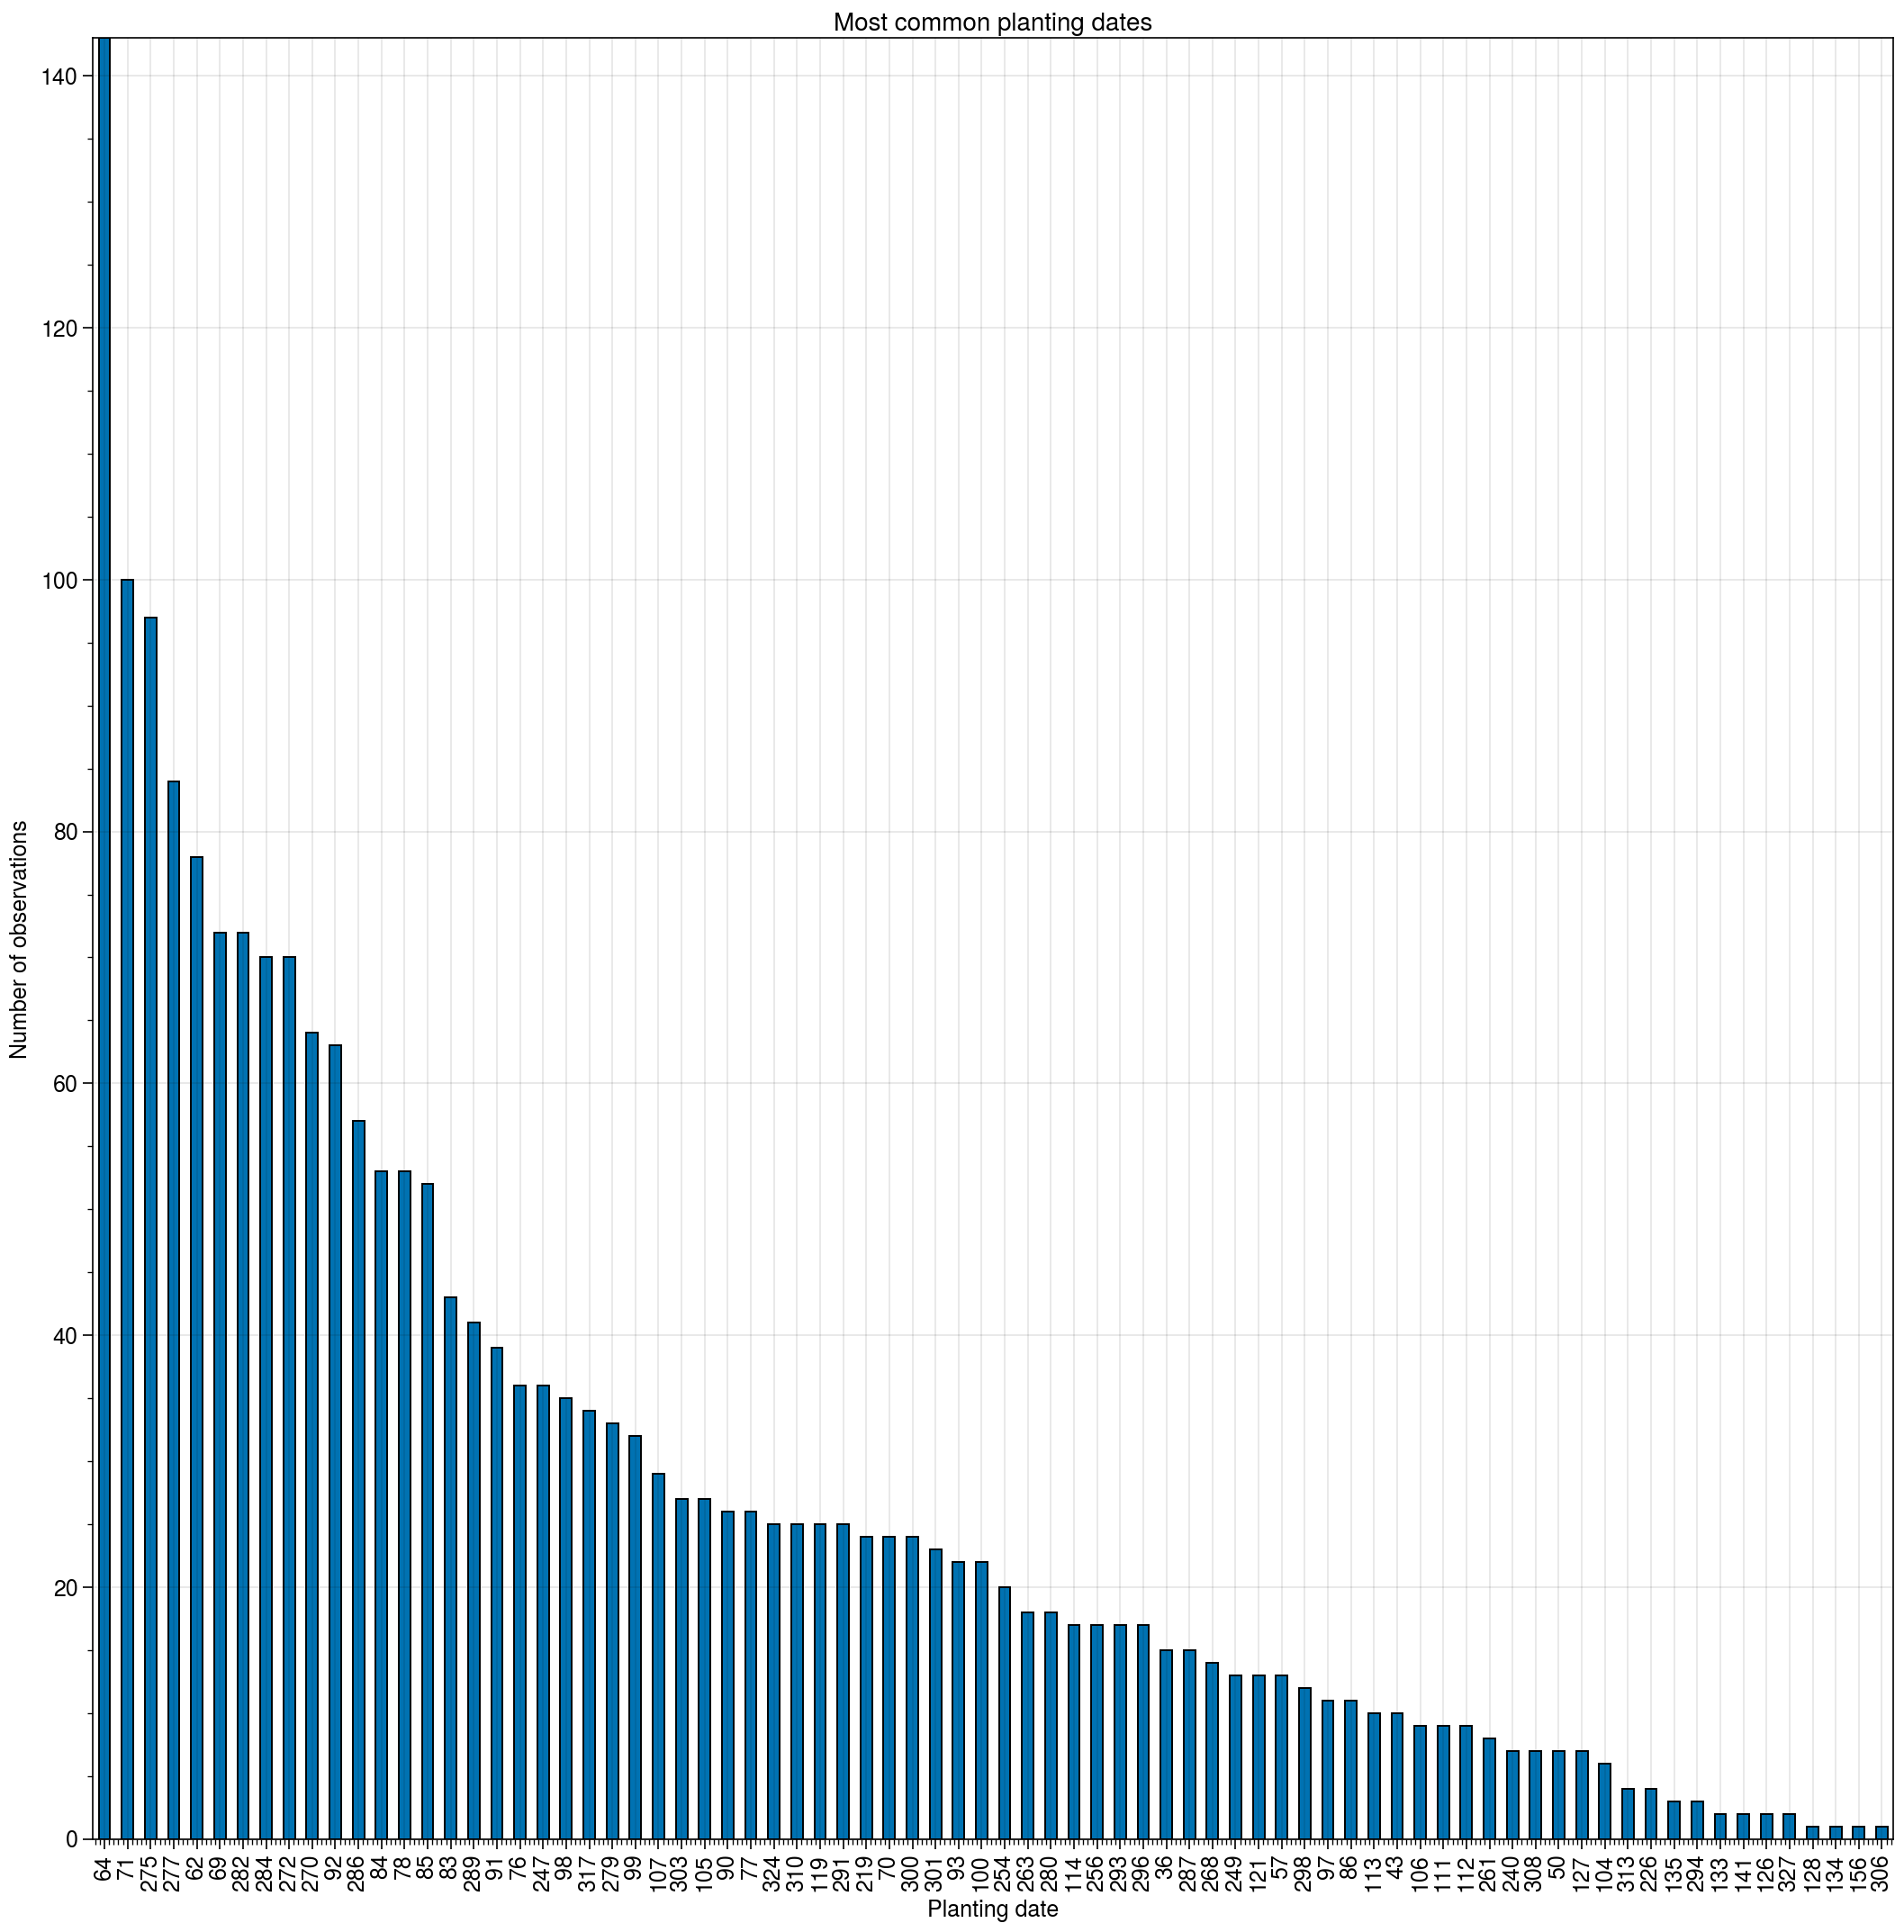

In [2]:
# data import will require file that is only available on Natasha's machine 

pds = pd.read_csv('../../../Kenya/planting-analysis/data/primary/SMS/L5/all_data_for_summary.csv',sep=',').drop(['Unnamed: 0','Latitude','Longitude'], axis=1); pds

# Convert datetime to Day of Year
pds['PD'] = pd.to_datetime(pds['PD'], errors='coerce')
pds['DOY'] = pds['PD'].dt.dayofyear

# Check out the distribution
#pds['DOY'].hist()

# Plug in these values for model runs
PDS = pds.DOY.tolist()

# TODO: Do I need only one farmer per planting date
# Or do some kind of weight based on planting date

# Frequency plots of planting date
fig, axs = plot.subplots(
        axwidth=10, 
    ) #nrows=1, ncols=1,
        #share=0, panelpad=0.1, includepanels=True

pds['DOY'].value_counts().plot(kind='bar')
plt.title('Most common planting dates')
plt.ylabel('Number of observations')
plt.xlabel('Planting date')

pds.Year.unique()
len(pds)

In [3]:
# get list of unique planting dates

pds = set(PDS)

# Most common planting dates
from collections import Counter
Counter(PDS)

len(pds)

78

In [7]:
# most up to date run 
def run(n_sim = 1000, burn_in = 60,  station = 'OL JOGI FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad'):
    """ Set up model conditions for model runs. 

    Usage: run(n_sim, burn_in, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = TODO

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    # doy = abs(burn_in - pd_sim) # absolute value
    doy = pd_sim - burn_in
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
    
    s0_climate = Climate(data_file=data_file, station=station, interval=interval)
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)

    
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy)
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
    models = [CropModel(
                  crop=crop,
                  climate=Climate(alpha_r=s0_climate.alpha_r, lambda_r=s0_climate.lambda_r),
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    # We imported printProgressBar from functions.py earlier:
    printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    output = []
    for i, model in enumerate(models):
        output.append(model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim))
        printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)

    #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    print("Step 5: \n\t...Subsetting data to growing period.")
 
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Output the dynamic stress and yield values (just added this 08-17-2020)
    # old: x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress) for df in output] #for i in np.arange(n_sim)
    print("Step 6: \n\t...Calculating plant stress.")

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output] # I have no clue whether this will work
    
    #print(output[0][start:end].s)
    rf = [df[start:end]['R'].sum() for df in output]
    
    return x, rf, int(lgp), avg_s, output, start, end, texture #, crop, station,  pd_sim, n_sim, burn_in


In [8]:
# make subset of PDs because this is taking too long
test_PDS = [50,100,100,200,250]

# Break up into 10 day increments
cal_pd = range(1,366,10)
len(cal_pd)

37

In [9]:
#len(PDS)

#uniquePDS = result.PDS.unique()
#PDS.unique()

#uniquePDS = pds

In [46]:
# run results for all planting dates
# TODO: Split these into 2 or 3 seasons

result = []
result_s = []

for i in cal_pd: # test_PDS, uniquePDS
    
    data, rf, lgp, avg_s, output, start, end, texture = run(n_sim = 1000, station = 'OL JOGI FARM', texture = 'loam', lgp=90, pd_sim=i)
    # Get yields
    df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
    df['RF'] = rf
    df['PDS'] = i
    result.append(df)
    
    # Get soil moisture time series
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1)
    result_s.append(avg_daily)
    
result = pd.concat(result)
result_s = pd.concat(result_s)

Step 1: 
	...Conducting burn in starting at doy 306, which is 60 days before the simulated planting date of 1.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as loam
	...Initializing crop with 90 days to maturity
	...Setting nZr parameter to 180.4
Step 3: 
	... Setting number of burn in simulations to 100
	...Computing average soil moisture for doy 306 using 100 simulations
		[s0_mean]:0.4973316701259142	[s0_std]:0.07478749109571003
Step 4: 
	... Running 1000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 316, which is 60 days before the simulated planting date of 11.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/m

		[s0_mean]:0.34557680559707754	[s0_std]:0.05699762772177227
Step 4: 
	... Running 1000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 51, which is 60 days before the simulated planting date of 111.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as loam
	...Initializing crop with 90 days to maturity
	...Setting nZr parameter to 180.4
Step 3: 
	... Setting number of burn in simulations to 100
	...Computing average soil moisture for doy 51 using 100 simulations
		[s0_mean]:0.3580019622660709	[s0_std]:0.05348688009049728
Step 4: 
	... Running 1000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data 

	...Initializing soil as loam
	...Initializing crop with 90 days to maturity
	...Setting nZr parameter to 180.4
Step 3: 
	... Setting number of burn in simulations to 100
	...Computing average soil moisture for doy 151 using 100 simulations
		[s0_mean]:0.5417098581897976	[s0_std]:0.06308955605185194
Step 4: 
	... Running 1000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 161, which is 60 days before the simulated planting date of 221.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as loam
	...Initializing crop with 90 days to maturity
	...Setting nZr parameter to 180.4
Step 3: 
	... Setting number of burn in simulations to 100
	...Computing average soil moisture for doy 161

Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting at doy 261, which is 60 days before the simulated planting date of 321.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as loam
	...Initializing crop with 90 days to maturity
	...Setting nZr parameter to 180.4
Step 3: 
	... Setting number of burn in simulations to 100
	...Computing average soil moisture for doy 261 using 100 simulations
		[s0_mean]:0.44781899795220986	[s0_std]:0.06568054297497077
Step 4: 
	... Running 1000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.
Step 1: 
	...Conducting burn in starting

In [47]:
# make the results data easier to plot
data = result.pivot(columns='PDS',values='Yield')
data.name = 'Yield (kg/ha)'

data.columns

data = pd.DataFrame(
     data,
     columns=pd.Index(data.columns, name='Planting Date')
)

data

Planting Date,1,11,21,31,41,51,61,71,81,91,...,271,281,291,301,311,321,331,341,351,361
0,0.0,0.438436,0.000000,1.646075,1.774060,1.336951,1.757766,1.628675,0.804690,1.551553,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.099521,1.156452,0.000000,1.440969,1.460438,1.067808,1.318180,0.000000,...,1.293998,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.383563,1.040857,1.807926,0.000000,0.758285,1.379168,...,0.000000,0.000000,0.362172,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.000000,1.706068,1.743693,1.673005,1.565502,0.000000,1.255996,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.160731,0.000000,0.000000,0.000000,1.807265,1.185182,1.621237,1.619931,0.566239,...,0.000000,0.000000,0.000000,1.033012,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.212029,0.000000,1.633367,1.705657,1.420537,1.361010,1.762428,1.624137,1.305582,...,1.159172,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.000000,0.115387,0.000000,1.536852,1.709090,1.590577,1.504989,1.343572,0.885675,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.000000,0.367334,0.000000,0.729389,1.550138,1.715598,1.352099,1.343314,1.677119,...,0.000000,0.836705,0.000000,0.078560,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.700908,0.014106,0.000000,1.528047,1.620462,1.760093,1.575361,0.864675,1.352381,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
result.PDS.min()
result.PDS.max()

data.columns

#print(cal_pd)

Int64Index([  1,  11,  21,  31,  41,  51,  61,  71,  81,  91, 101, 111, 121,
            131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251,
            261, 271, 281, 291, 301, 311, 321, 331, 341, 351, 361],
           dtype='int64', name='Planting Date')

In [49]:
labels = list(cal_pd)
labels

# Some plotting magic from here: https://matplotlib.org/3.2.1/gallery/ticks_and_spines/tick_labels_from_values.html
def format_fn(tick_val, tick_pos):
    if int(tick_val) in cal_pd:
        return labels[int(tick_val)]
    else:
        return ''


/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/proplot/utils.py:105: ProPlotWarning: You specified both height=7 and axwidth=2.5. Ignoring 'axwidth'.
/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/proplot/utils.py:134: UserWarning: Got conflicting or duplicate keyword args: {'lw': 0.7, 'linewidth': 0.7}. Using the first one.
  warnings.warn(


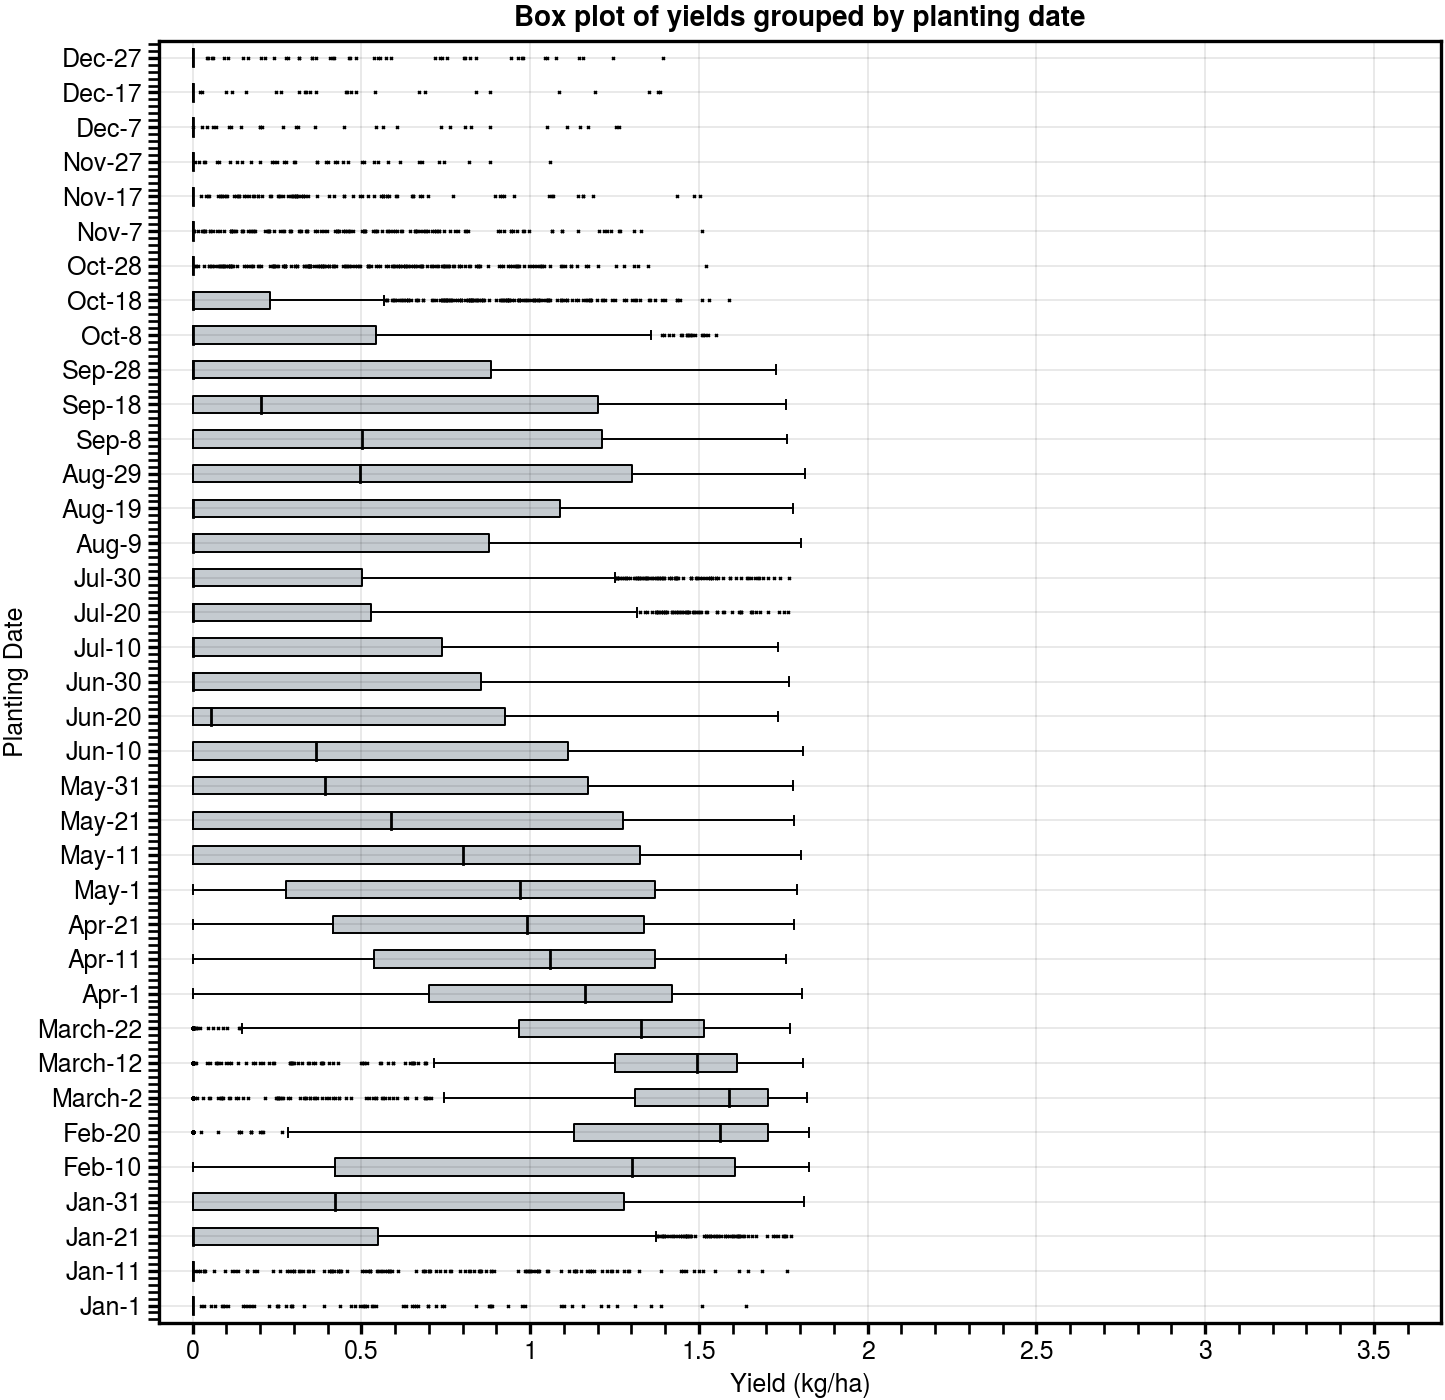

In [50]:
plot.rc.update(
    linewidth=1.2, fontsize=3, ticklenratio=1,
    figurefacecolor='w', facecolor='white',
    titleloc='upper center', titleborder=False,
)

# Fit boxplots to planting dates
result.PDS.nunique()

#result.boxplot(column='Yield', by='PDS')

# Generate figure
fig, axs = plot.subplots(ncols=1, axwidth=2.5, height=7)
axs.format(grid=True, suptitle='Box plot of yields grouped by planting date')

# Box plots
ax = axs[0]
obj1 = ax.boxplot(
    data, lw=0.7, marker='x', fillcolor='gray5',markersize=1,orientation='horizontal',
    medianlw=1, mediancolor='k'
)
ax.format(ylabel='Planting Date') #, title='Bar plot', ygrid=False)

ax.format(xlabel='Yield (kg/ha)') #, title='Bar plot', ygrid=False)

# For cal pds
from matplotlib.ticker import FuncFormatter, MaxNLocator
ax.yaxis.set_major_formatter(FuncFormatter(format_fn))
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# User input labels
axs[0].format(
#    ylim=(0, 79.5), ylocator=2,
# deleted every other one
#             yticklabels=[ '36',   '50',    '62',   '69',  '71',  '77',    '83',
#              '85',   '90',   '92',   '97', '99',  '104', 
#             '106',  '111',  '113',  '119',  '126',  '128',  '134',
#            '141',  '219',  '240',  '249',  '256',  '263', 
#         '270',  '275',  '279',  '282',  '286',  '289',  '293',
#              '296',  '300',  '303',  '308', '313',  '324','327'],
     xlim=(-0.1, 3.7), # 3.7
    # only for cal pd
    ylocator=1,
      yticklabels=[ 'Jan-1',   'Jan-11',    'Jan-21',   'Jan-31',  'Feb-10',  'Feb-20',    'March-2',
              'March-12',   'March-22',   'Apr-1',   'Apr-11', 'Apr-21',  'May-1', 
             'May-11',  'May-21',  'May-31',  'Jun-10',  'Jun-20',  'Jun-30',  'Jul-10',
            'Jul-20',  'Jul-30',  'Aug-9',  'Aug-19',  'Aug-29',  'Sep-8', 
         'Sep-18',  'Sep-28',  'Oct-8',  'Oct-18',  'Oct-28',  'Nov-7', 'Nov-17', 'Nov-27',
              'Dec-7',  'Dec-17',  'Dec-27']
)

# actual labels
  #  yticklabels=[ '36',  '43',  '50',  '57',  '62',  '64',  '69',  '70',  '71',  '76',  '77',  '78',  '83',
  #           '84',  '85',  '86',  '90',  '91',  '92',  '93',  '97',  '98',  '99', '100', '104', '105',
  #          '106', '107', '111', '112', '113', '114', '119', '121', '126', '127', '128', '133', '134',
  #          '135', '141', '156', '219', '226', '240', '247', '249', '254', '256', '261', '263', '268',
  #      '270', '272', '275', '277', '279', '280', '282', '284', '286', '287', '289', '291', '293',
  #          '294', '296', '298', '300', '301', '303', '306', '308', '310', '313', '317', '324', '327']

#ax.format(title='Box plots', titleloc='uc')

# Violin plots
#ax = axs[1]
#obj2 = ax.violinplot(
#    data, lw=0.7, fillcolor='gray7',
#    points=500, bw_method=0.3, means=True
#)
#ax.format(title='Violin plots', titleloc='uc')

## Make time series

Text(0.5, 1.0, 'Average maize yield with 90th and 10th quantile intervals, 180-d variety')

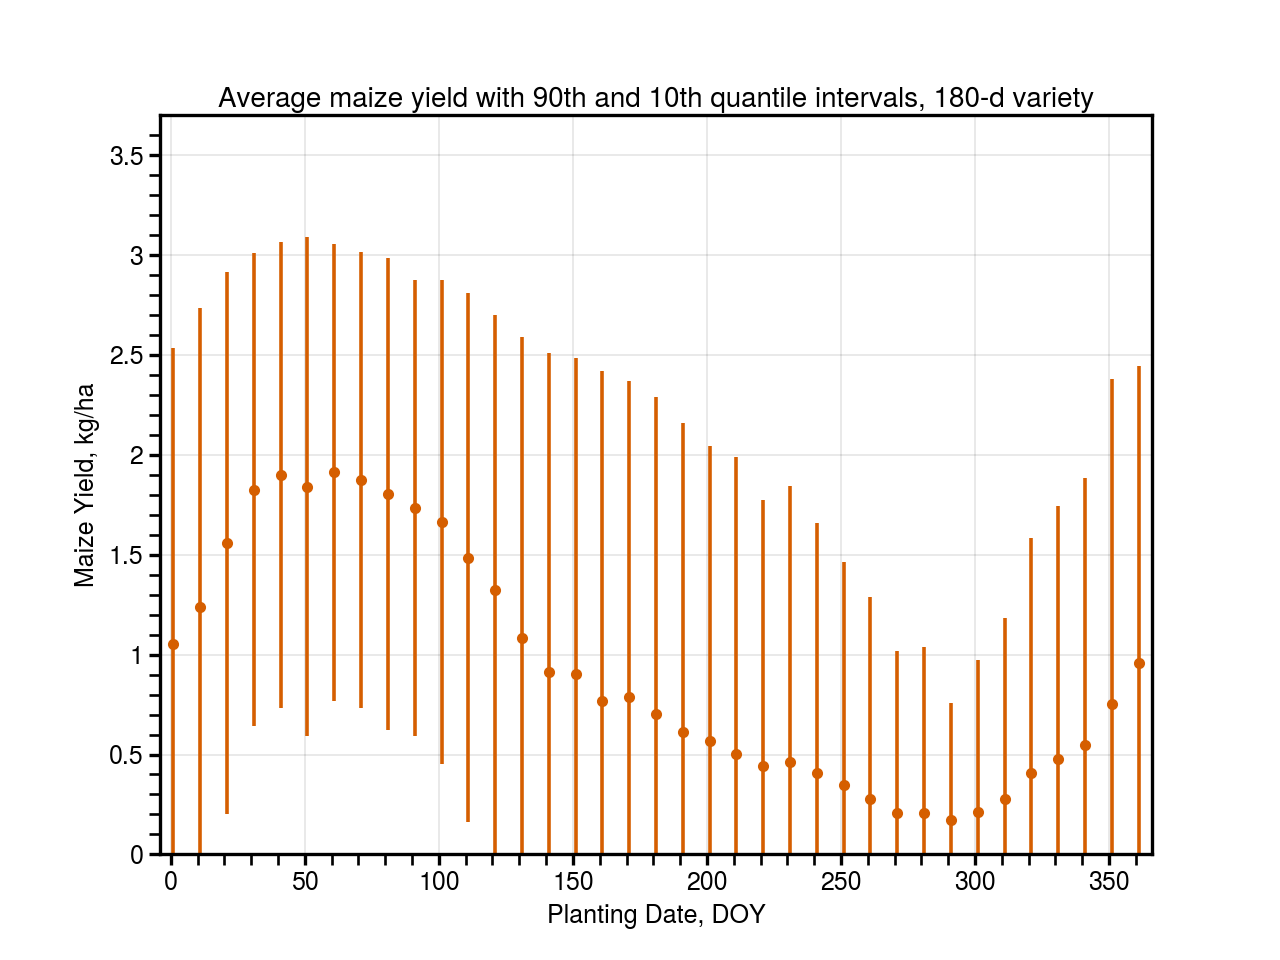

In [45]:
# FOR 180D VARIETY
data.T
result
#ax = sns.regplot(x="Planting Date", data=data.T, x_estimator=np.mean, logx=True)

# Plot average yield per planting date
result.groupby('PDS')['Yield'].mean().plot(style='.')

quant_x = result.groupby('PDS')['Yield'].quantile([.1])
quant_y = result.groupby('PDS')['Yield'].quantile([.9])
# need to subtract mean
quant_y=quant_y-result.groupby('PDS')['Yield'].mean()
#quant = result.groupby('PDS')['Yield'].quantile([.1, .9])
x = np.arange(1, 365, 10)

plt.errorbar(x, result.groupby('PDS')['Yield'].mean(), xerr=quant_x , yerr=quant_y, fmt='o')
plt.ylim(0,3.7)
plt.xlim(-4,366)
plt.ylabel('Maize Yield, kg/ha')
plt.xlabel('Planting Date, DOY')
#plt.legend(['Average'])
plt.title('Average maize yield with 90th and 10th quantile intervals, 180-d variety')
#plt.fill_between(x, quant[0.1], quant[0.9] ,facecolor='gainsboro')


Text(0.5, 1.0, 'Average maize yield with 90th and 10th confidence intervals, 90-d variety')

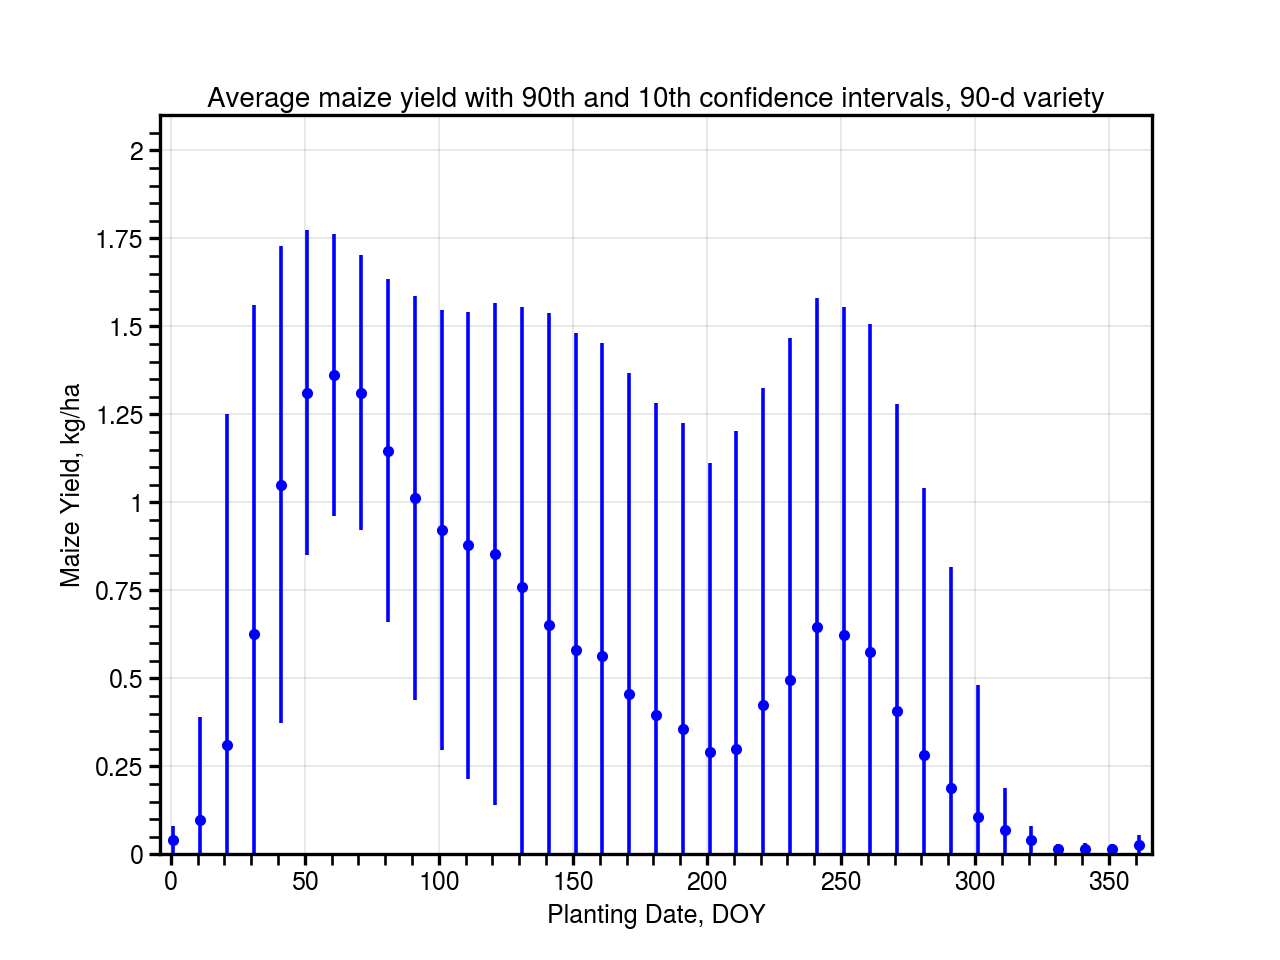

In [53]:
# FOR 900D VARIETY
data.T
result
#ax = sns.regplot(x="Planting Date", data=data.T, x_estimator=np.mean, logx=True)

# Plot average yield per planting date
result.groupby('PDS')['Yield'].mean().plot(style='.')

quant_x = result.groupby('PDS')['Yield'].quantile([.1])
quant_y = result.groupby('PDS')['Yield'].quantile([.9])
# need to subtract mean
quant_y=quant_y-result.groupby('PDS')['Yield'].mean()
#quant = result.groupby('PDS')['Yield'].quantile([.1, .9])
x = np.arange(1, 365, 10)

plt.errorbar(x, result.groupby('PDS')['Yield'].mean(), xerr=quant_x , yerr=quant_y, fmt='bo')
plt.ylim(0,2.1)
plt.xlim(-4,366)
plt.ylabel('Maize Yield, kg/ha')
plt.xlabel('Planting Date, DOY')
#plt.legend(['Average'])
plt.title('Average maize yield with 90th and 10th confidence intervals, 90-d variety')
#plt.fill_between(x, quant[0.1], quant[0.9] ,facecolor='gainsboro')


In [ ]:
fig, axs = plot.subplots(ncols=1, axwidth=2.5, height=7)
axs.format(grid=True, suptitle='Box plot of yields grouped by planting date')

# Box plots
ax = axs[0]
obj1 = ax.boxplot(
    data, lw=0.7, marker='x', fillcolor='gray5',markersize=1,orientation='horizontal',
    medianlw=1, mediancolor='k'
)
ax.format(ylabel='Planting Date') #, title='Bar plot', ygrid=False)
ax.format(xlabel='Yield (kg/ha)') #, title='Bar plot', ygrid=False)

In [40]:
output

[      kc       LAI    stress          R         s         E        ET  \
 0    0.3  0.750000  0.230773   8.417010  0.491080  1.095423  1.899567   
 1    0.3  0.750000  0.132385   0.000000  0.527207  1.037829  1.801212   
 2    0.3  0.750000  0.156860   0.000000  0.517223  0.984183  1.708916   
 3    0.3  0.750000  0.181999  25.094960  0.507750  1.749828  2.949828   
 4    0.3  0.750000  0.000938   2.764876  0.630506  1.743219  2.943219   
 ..   ...       ...       ...        ...       ...       ...       ...   
 152  0.6  2.500000  0.552524  28.963243  0.409571  0.533132  3.631468   
 153  0.6  2.589286  0.084304   3.908156  0.549991  0.513412  3.742900   
 154  0.6  2.678571  0.082597   0.000000  0.550907  0.445650  3.499664   
 155  0.6  2.767857  0.122483   0.000000  0.531508  0.386932  3.265611   
 156  0.6  2.857143  0.166766   0.000000  0.513405  0.336111  3.040708   
 
             T    L       dsdt   dos  doy  
 0    0.804143  0.0   6.517443   0.0  301  
 1    0.763383  0.0  -

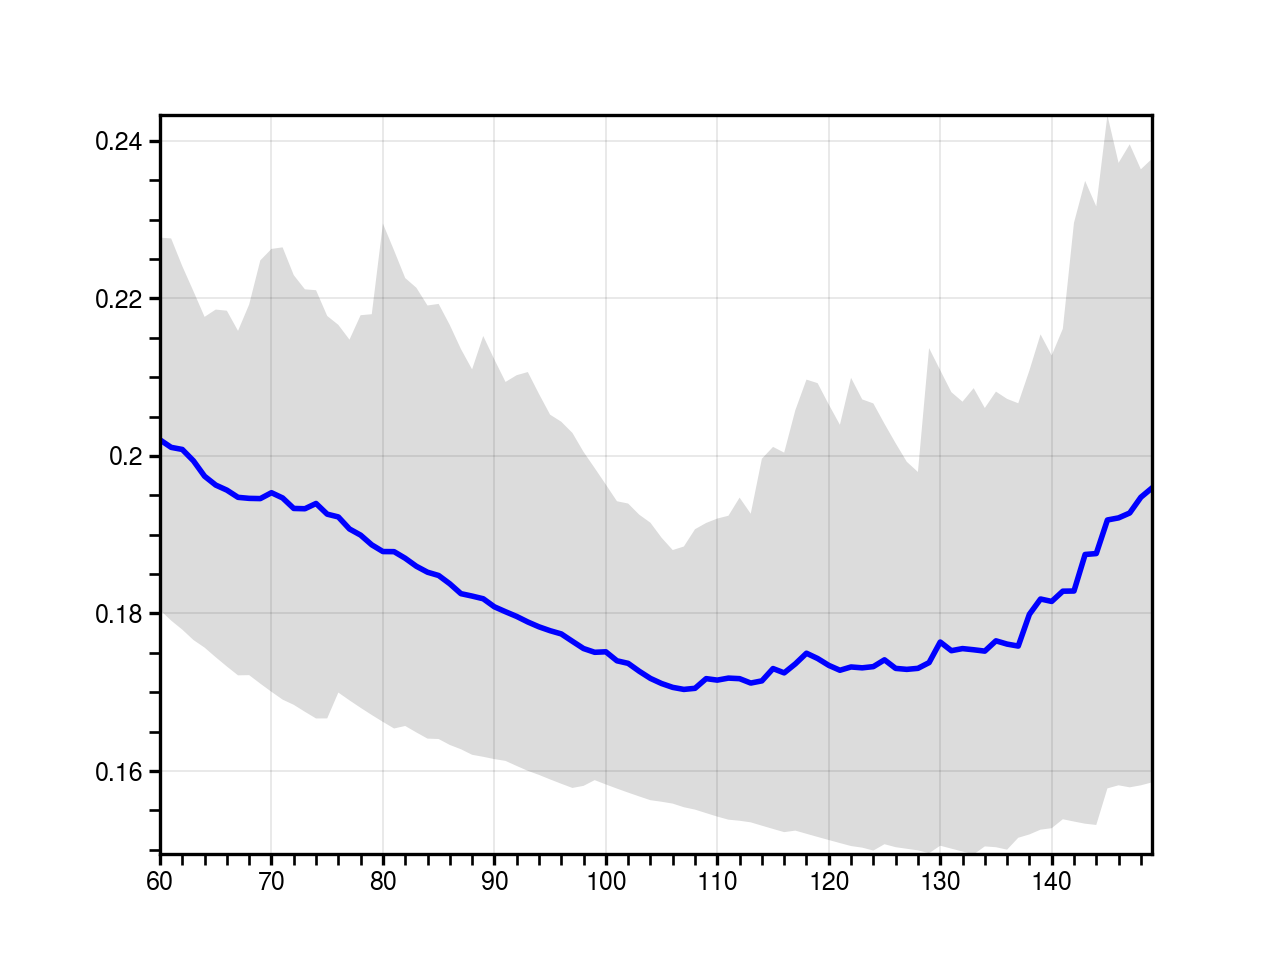

In [44]:
output # This is for the 90 day variety
texture='clay loam'
# Figure b: Soil moisture time series
avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
avg_daily = avg_daily*Soil(texture).n; avg_daily
avg_daily_t = avg_daily.T; avg_daily_t
daily_mean = avg_daily.mean(axis=1); daily_mean
daily_mean.index = daily_mean.index # Change index so that we can see day of season
daily_mean
col='blue'
plt.plot(daily_mean, color=col, lw=2)

x = np.arange(start, end, 1)

quant = avg_daily_t.quantile([.1, .9])
quant = quant.T
plt.fill_between(x, quant[0.1], quant[0.9] ,facecolor='gainsboro')

# Actually I dont think this is whaat he means 

## Average soil moisture by planting date

In [ ]:
# Need a subplot with 37 boxes, 5 by 8?

f, axs = plot.subplots(nrows=8, ncols=5, axwidth=1.2, aspect=1)
axs.format(abc=True, abcloc='ul', xlabel='Day of Year', ylabel='Volumetric Water Content / mm',
        xticks=1, yticks=1, suptitle='') 
for ax, i in zip(axs, cal_pd):
    ax.bar(_lambda, color=(0.2, 0.4, 0.6, 0.6))
    
    
    
    
    #ax.format(xtickminor=False,ytickminor=True,ylim=(0, 1),
    #xticklabels=['J', 'F', 'M', 'A', 'M','J','J','A','S','O','N','D'])

In [39]:
cal_pd

range(1, 366, 10)

In [ ]:
data
descrip = data.describe()
descrip

df=data.T
df
perc_fail = pd.DataFrame((df == 0).astype(int).sum(axis=1)/len(df)*100)
perc_fail
descrip = descrip.T
descrip
descrip['Percent Failure'] = perc_fail
descrip
descrip.sort_values(by=['Percent Failure'],axis=0).head(20)

### Let's get some summary statistics for all of the planting dates

In [ ]:
descrip = data.describe()
descrip.sort_values(by='mean',axis=1)
descrip.sort_values(by='std',axis=1)

# Let's add percentage of crop failure
data

#c_e = len(early.loc[early['Yield'] == 0].count(axis=1))/len(early)*100
df=data.T
perc_fail = pd.DataFrame((df == 0).astype(int).sum(axis=1)/len(df)*100)
descrip = descrip.T
descrip['Percent Failure'] = perc_fail
descrip
descrip.sort_values(by=['Percent Failure'],axis=0)

descrip_top5 = descrip.drop(['count','min','25%','50%'],axis=1)
#descrip_top5.sort_values(by=['mean'],axis=1)
descrip_top5

# Could do this manually:
pf = descrip.sort_values(by=['Percent Failure'],ascending=True, axis=0).head(5).index
mn = descrip.sort_values(by=['mean'],ascending=False, axis=0).head(5).index
sd = descrip.sort_values(by=['std'],ascending=True, axis=0).head(5).index
sf=descrip.sort_values(by=['75%'],ascending=False, axis=0).head(5).index
mx=descrip.sort_values(by=['max'],ascending=False, axis=0).head(5).index

table_top5 = pd.DataFrame({'Mean':mn,
                       'Standard Deviation': sd,
                       '75%': sf,
                       'Maximum':mx,
                       'Percent Failure':pf})
table_top5

In [ ]:
# Lowest five
descrip_low5 = descrip.drop(['count','min','25%','50%'],axis=1)
#descrip_top5.sort_values(by=['mean'],axis=1)
descrip_low5

pf = descrip.sort_values(by=['Percent Failure'],ascending=False, axis=0).head(5).index
mn = descrip.sort_values(by=['mean'],ascending=True, axis=0).head(5).index
sd = descrip.sort_values(by=['std'],ascending=False, axis=0).head(5).index
sf=descrip.sort_values(by=['75%'],ascending=True, axis=0).head(5).index
mx=descrip.sort_values(by=['max'],ascending=True, axis=0).head(5).index

table_low5 = pd.DataFrame({'Mean':mn,
                       'Standard Deviation': sd,
                       '75%': sf,
                       'Maximum':mx,
                       'Percent Failure':pf})
table_low5

In [ ]:
result.groupby('PDS')['Yield'].mean()

result.Yield.hist(by=result.PDS)

In [ ]:
for col in data.columns: #np.arange(1, 78):
    #ax = axs[col - 1]
    #ax.set_title(month_abbrs[mth])
    #result.Yield.hist(by=result.PDS)
    sns.distplot(list(data[col]), ax=ax, **{'kde': False})